# **Data Collection**

## Objectives

* Download data from Kaggle.com and perform an initial EDA.

## Inputs

* unclean_smartwatch_health_data.csv

## Outputs

* ydata-profiling EDA

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Predictive_Analytics_Project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Predictive_Analytics_Project'

Locate our clean data files

In [4]:
CleanedDataFolder = "inputs/cleaned_data/"
OutputFolder = "outputs/"
HypothesisOneFolder = CleanedDataFolder + "hypothesis_one_data/"
HypothesisTwoFolder = CleanedDataFolder + "hypothesis_two_data/"
HypothesisThreeFolder = CleanedDataFolder + "hypothesis_three_data/"

Load the cleaned data into variables

In [5]:
import pandas as pd
# Hypothesis 1
data = pd.read_csv(HypothesisOneFolder + "cleaned_smartwatch_health_data.csv")
df1 = pd.DataFrame(data)
# Hypothesis 2
data2 = pd.read_csv(HypothesisTwoFolder + "cleaned_smartwatch_health_data.csv")
df2 = pd.DataFrame(data2)
# Hypothesis 3
data3 = pd.read_csv(HypothesisThreeFolder + "cleaned_smartwatch_health_data.csv")
df3 = pd.DataFrame(data3)

# Section 2 Normality, Skewness and Kurtosis Improvement


Lets try improve the datasets numerical variables distriubtions and such

In [6]:
# check min and max for numeric variables to see if boxcox is suitable
for col in df1:
    if df1[col].dtype == "float64" or df1[col].dtype == "int64":
        print(f"{col} min: {df1[col].min()}, max: {df1[col].max()}")

df1.head()

Heart Rate (BPM) min: 40.0, max: 113.99508338123148
Blood Oxygen Level (%) min: 92.7675119453897, max: 100.0
Step Count min: 0.9101380609604088, max: 21144.291453190403
Sleep Duration (hours) min: 2.6394569674224493, max: 10.37828858094464
Stress Level min: 1, max: 11


,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,58.939776,98.809650,5450.390578,7.167236,Highly Active,1
1,75.220601,98.532195,727.601610,6.538239,Highly Active,5
2,113.995083,97.052954,2826.521994,6.503308,Highly Active,5
3,40.000000,96.894213,13797.338044,7.367790,Active,3
4,61.950165,98.583797,15679.067648,6.503308,Highly Active,6


As we dont have any negative values, The BoxCox Transformer seems appropriate to try first.

*** Heart Rate (BPM) ***


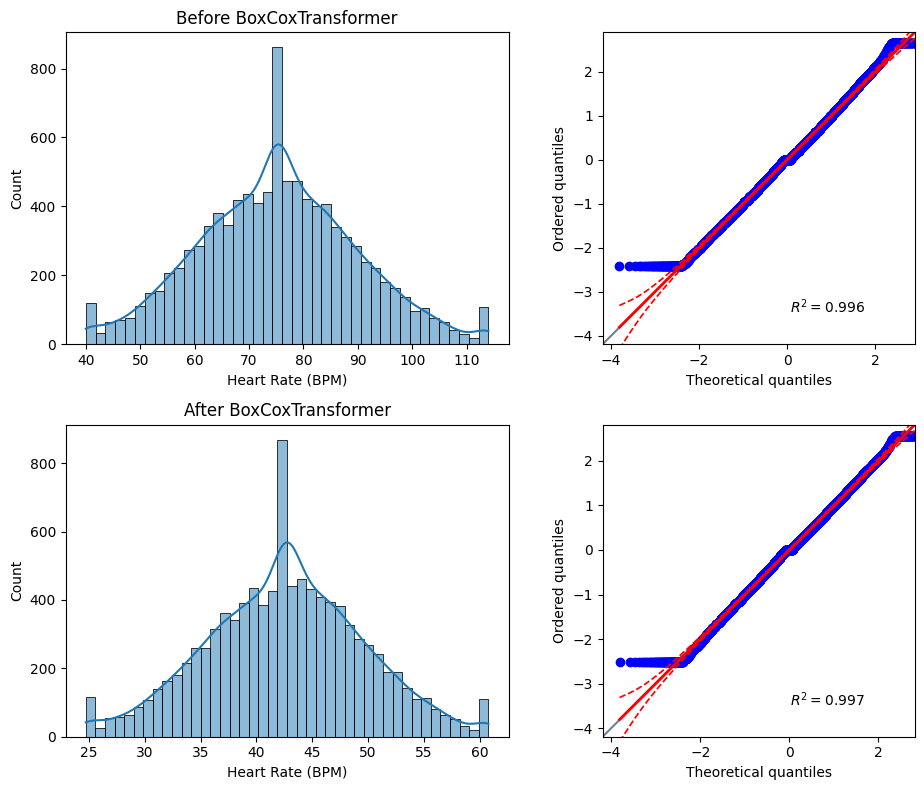

before transformation  | skewness: 0.09 | kurtosis: -0.1
after transformation  | skewness: -0.01 | kurtosis: -0.11


*** Blood Oxygen Level (%) ***


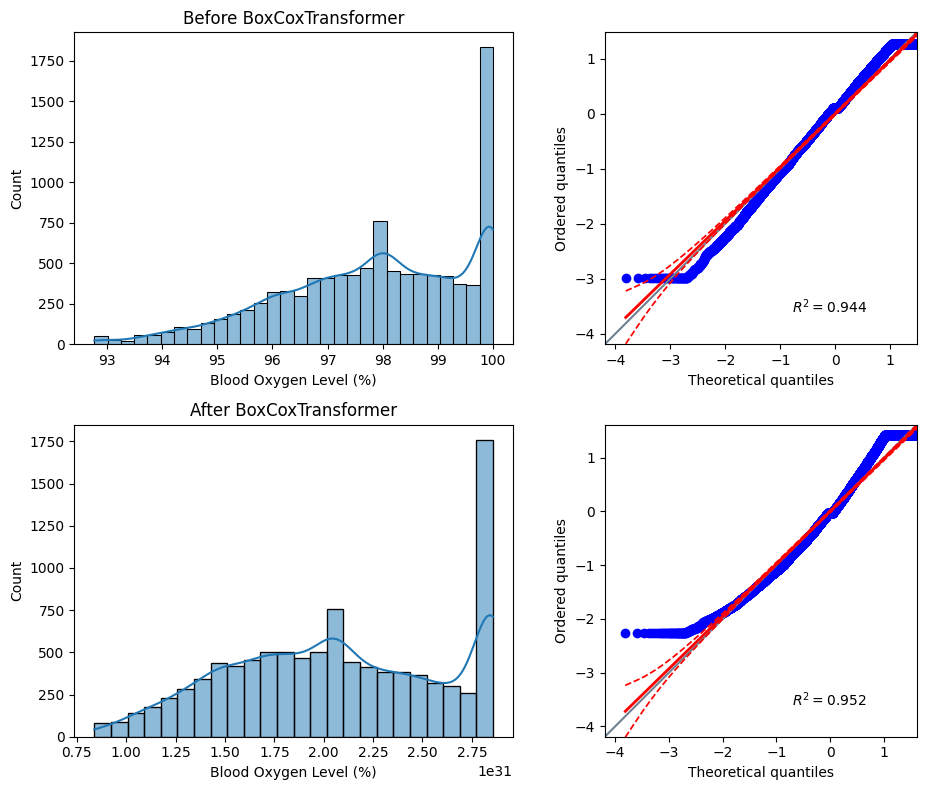

before transformation  | skewness: -0.56 | kurtosis: -0.37
after transformation  | skewness: -0.1 | kurtosis: -1.02


*** Step Count ***


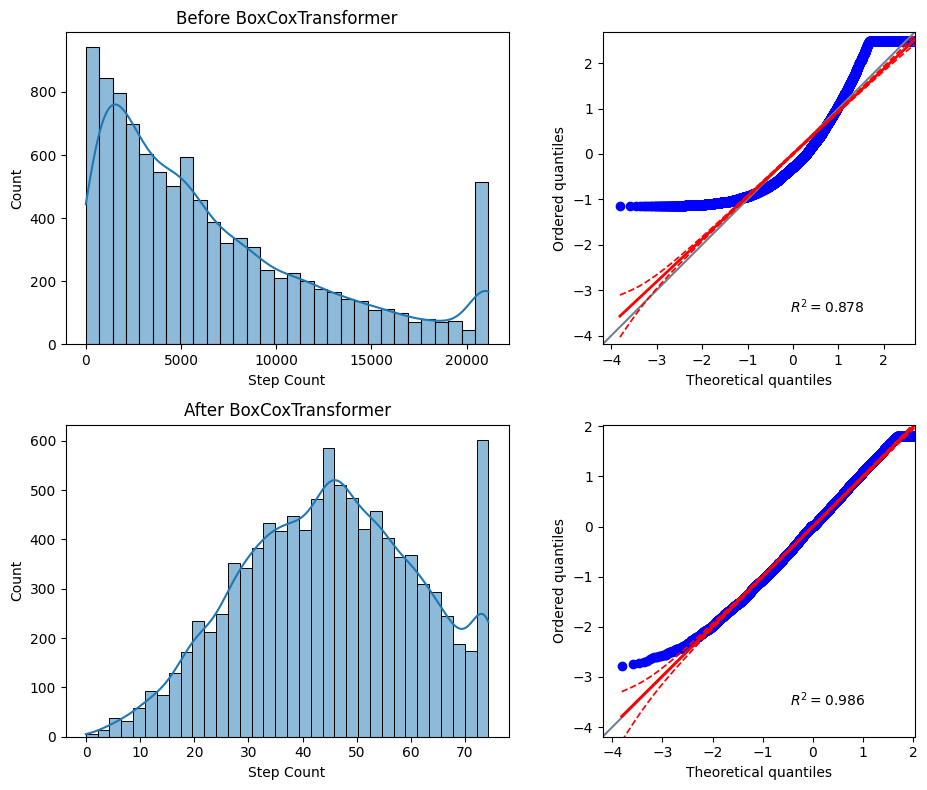

before transformation  | skewness: 1.05 | kurtosis: 0.21
after transformation  | skewness: -0.09 | kurtosis: -0.64


*** Sleep Duration (hours) ***


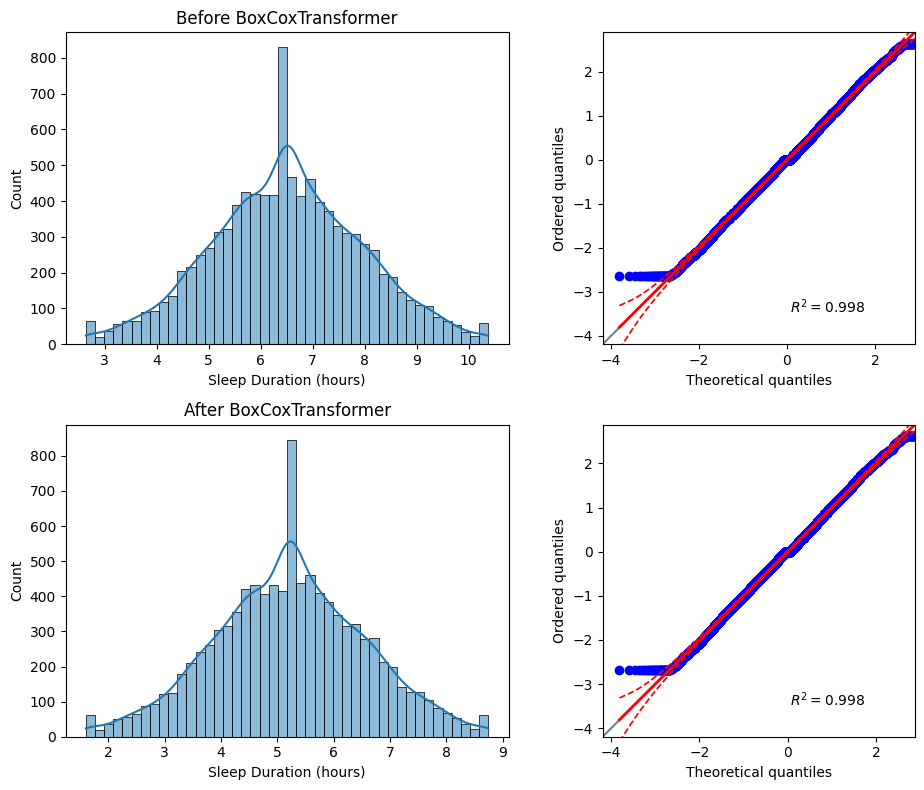

before transformation  | skewness: 0.02 | kurtosis: -0.13
after transformation  | skewness: -0.01 | kurtosis: -0.12


*** Stress Level ***


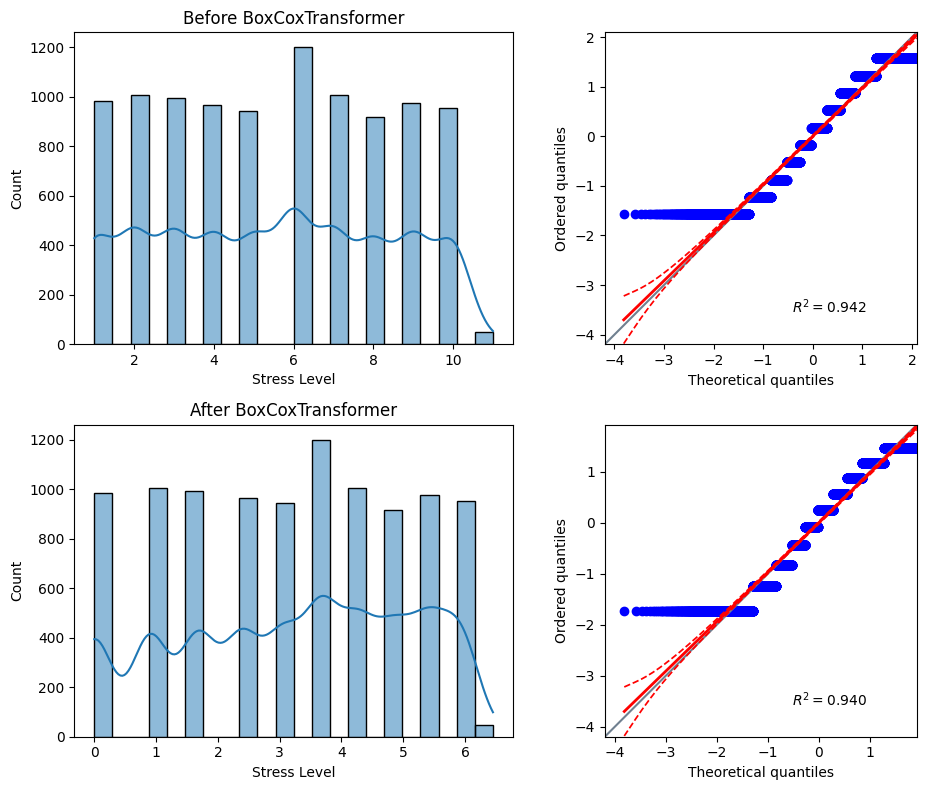

before transformation  | skewness: 0.01 | kurtosis: -1.18
after transformation  | skewness: -0.2 | kurtosis: -1.1




In [7]:
from sklearn.pipeline import Pipeline
from feature_engine import transformation as vt
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt

df_numeric = df1.select_dtypes(include=['float64','int64'])

def calculate_skew_kurtosis(df,col, moment):
  print(f"{moment}  | skewness: {df[col].skew().round(2)} | kurtosis: {df[col].kurtosis().round(2)}")


pipeline = Pipeline([
      ( 'boxcox', vt.BoxCoxTransformer() )
  ])

df_transformed = pipeline.fit_transform(df_numeric)

def compare_distributions_before_and_after_applying_transformer(df, df_transformed, method):

  for col in df.columns:
    print(f"*** {col} ***")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

    sns.histplot(data=df, x=col, kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Before {method}')
    pg.qqplot(df[col], dist='norm',ax=axes[0,1])
    
    sns.histplot(data=df_transformed, x=col, kde=True, ax=axes[1,0])
    axes[1,0].set_title(f'After {method}')
    pg.qqplot(df_transformed[col], dist='norm',ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()
    
    # Save plot
    plot_names = method + "_" + col + ".png"
    # Add a subfolder to the output folder for normality and skewness improvement plots
    NormalitySkewness = os.path.join(OutputFolder, f"norm_skew_improvement/{method}/")
    if not os.path.exists(NormalitySkewness):
        os.makedirs(NormalitySkewness)
    plot_dir = os.path.join(NormalitySkewness, plot_names)
    fig.savefig(plot_dir)
    

    calculate_skew_kurtosis(df,col, moment='before transformation')
    calculate_skew_kurtosis(df_transformed,col, moment='after transformation')
    print("\n")
    
compare_distributions_before_and_after_applying_transformer(df_numeric, df_transformed, method='BoxCoxTransformer')

The results are good from the BoxCox Transformer

The Log Transformer did not perform as well as the BoxCox

Lets also try the Power Tranformer

Power Transformer did not perform as well as the Box Cox, we will setlle for the BoxCox transformation.

In [8]:
# Define function to apply boxcox and also return the data back to a dataframe
def apply_boxcox(df):
    pipeline = Pipeline([
      ( 'log', vt.BoxCoxTransformer() ) 
    ])
    df_transformed = pipeline.fit_transform(df)
    df_transformed = pd.DataFrame(df_transformed, columns=df.columns)
    return df_transformed

In [9]:
boxcox = vt.BoxCoxTransformer()
df1_transformed = apply_boxcox(df1.copy())
df2_transformed = apply_boxcox(df2.copy())
df3_transformed = apply_boxcox(df3.copy())

## Cluster optimising

Lets now perform the other transformers we will need for a unsupervised clustering ML task

In [10]:
import numpy as np
from sklearn.pipeline import Pipeline
# scaling
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OrdinalEncoder 
# pca
from sklearn.decomposition import PCA
# kmeans
from sklearn.cluster import KMeans

def ClusterPipeline():
    pipeline_cluster_base = Pipeline([
        ('encoder', OrdinalEncoder(encoding_method='arbitrary', variables=["Activity Level"])),
        # I have chosen OrdinalEncoder as our categorical variables have an ordinal relationship
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)),
        ('kmeans', KMeans(n_clusters=50, random_state=42))
    ])
    return pipeline_cluster_base

pipeline_cluster = ClusterPipeline()

Perform PCA on a copied pipeline to find the best number of components for the parameter

In [11]:
# exclude the last two steps of the pipeline, to determine the optimal number of components first
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df1_transformed)

n_components = 6 # as 6 columns are present in the dataset
pca = PCA(n_components=n_components).fit(df_pca)
x_PCA = pca.transform(df_pca)

ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# print how much the variance is explained by each component
ProcessedData = dfExplVarRatio["Explained Variance Ratio (%)"].sum()

print(f"* The {n_components} components explain {round(ProcessedData, 2)}% of the data \n")
print(dfExplVarRatio)

* The 6 components explain 100.0% of the data 

             Explained Variance Ratio (%)
Component 0                        17.049
Component 1                        16.806
Component 2                        16.734
Component 3                        16.666
Component 4                        16.488
Component 5                        16.256


It seems 6 componenets explains 100% of the data, and lowering those components will lower the explained variance on average about 16.555% everytime a component is removed. So i feel we keep components at 6.


We update our now researched components for PCA

In [12]:
def ClusterPipeline():
    pipeline_cluster_base = Pipeline([
        ('encoder', OrdinalEncoder(encoding_method='arbitrary', variables=["Activity Level"])),
        # I have chosen OrdinalEncoder as our categorical variables have an ordinal relationship
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=6, random_state=42)), # 6 components explain 100% of the data
        ('kmeans', KMeans(n_clusters=50, random_state=42))
    ])
    return pipeline_cluster_base

pipeline_cluster = ClusterPipeline()

I must now find the best value for n_clusters by combining an elbow method and silhouette score

In [13]:
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df1_transformed)

print(df_analysis.shape, '\n', type(df_analysis))

(10000, 6) 
 <class 'numpy.ndarray'>


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

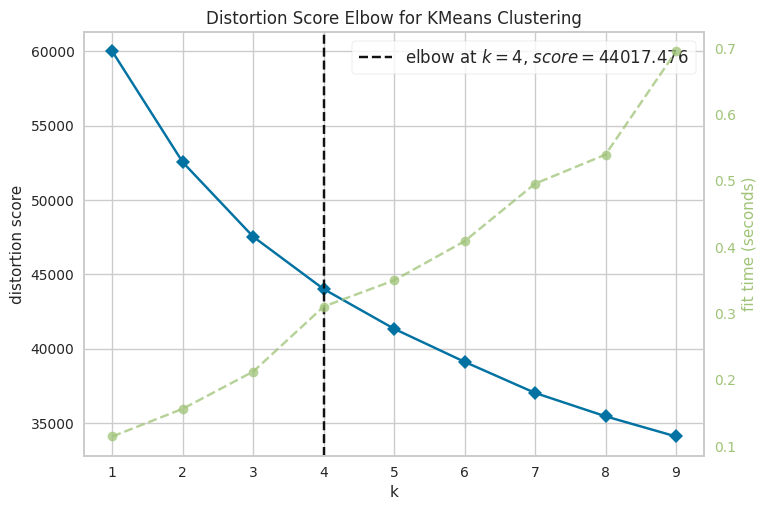

In [14]:
from yellowbrick.cluster import KElbowVisualizer

viz = KElbowVisualizer(KMeans(random_state=42), k=(1,10))
viz.fit(df_analysis)
viz.show()
plt.show()

The eblow point in the plot we just generated suggests a Kmeans clustering with 4 clusters, and the distortion around this level for the data points looks close/tight enough to respective centroids.

Now we perform a silhouette score to dive a bit more deeply into finding the best number of clusters

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=(2, 7), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")

for n_clusters in np.arange(start=2, stop=11):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=42),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

So the first elbow method method performed suggested 4 clusters, the average silhouette score suggested 2 clusters, although i feel that 4 clusters seems optimal from the silhouette plot with 4 centers seems evenly sized with minimal data points that ared under 0.0.

We will try 4 clusters for the first version of this model

In [15]:
def ClusterPipeline():
    pipeline_cluster_base = Pipeline([
        ('encoder', OrdinalEncoder(encoding_method='arbitrary', variables=["Activity Level"])),
        # I have chosen OrdinalEncoder as our categorical variables have an ordinal relationship
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=6, random_state=42)), # 6 components explain 100% of the data
        ('kmeans', KMeans(n_clusters=4, random_state=42)) #  4 clusters are chosen after the above analysis
    ])
    return pipeline_cluster_base

ClusterPipeline()

Pipeline(steps=[('encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Activity Level'])),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=6, random_state=42)),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

We have now done the feature engineering required for our unsupervised clustering task, the next job for this will be to adjust hyperparameters and fit the pipeline to find out our cluster predictions. For now we will feature engineer our correlation task from hypothesis 2 and 3.

---

## Feature Engineering for Hypothesis 2 and 3

Here we will perform feature selection for the Stress Level and Step Count variables to see if there is any suitable or obvious way to predict these variables, or perhaps it is not possible and it better off left as a traditional data analysis problem, which I have already studied. As a foresight in think both the hypothesis 2 and 3 will be null hypothesis as it doesnt look like there is any feature in the dataset that has a good prediction rate for these targets.

In [16]:
from feature_engine.selection import SmartCorrelatedSelection

pipeline_hypothesis_one = Pipeline([
    ('ord_encoder', OrdinalEncoder(encoding_method='arbitrary', variables=["Activity Level"])),
    ('smrt_corr_features', SmartCorrelatedSelection(method='pearson', threshold=0.1, selection_method='variance')),
])

df2_corr = pipeline_hypothesis_one.fit_transform(df2.copy())

print(pipeline_hypothesis_one['smrt_corr_features'].correlated_feature_sets_)
pipeline_hypothesis_one['smrt_corr_features'].features_to_drop_

[]


[]

None of the columns in this dataset are correlated above 0.1, this isnt a great sign for the non-clustering side of the business requirements

Lets try the embedden method of feature selection also. lets split the Test and Train data we collected in the cleaned_data folder under hypothesis 2 and 3

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Stress Level'],axis=1),
                                                    df2['Stress Level'],
                                                    test_size=0.2,
                                                    random_state=101)

# Is good practice to inspect the shape of the Train and Test sets.
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (8000, 5) (8000,) 
* Test set: (2000, 5) (2000,)


In [18]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2.drop(['Step Count'],axis=1),
                                                    df2['Step Count'],
                                                    test_size=0.2,
                                                    random_state=101)

# Is good practice to inspect the shape of the Train and Test sets.
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (8000, 5) (8000,) 
* Test set: (2000, 5) (2000,)


## Hypothesis 2 feat scaling and selection

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

pipeline = Pipeline([
      ( "ord_encode", OrdinalEncoder(encoding_method='arbitrary', variables=["Activity Level"]) ),
      ( "feature_scaling", StandardScaler() ),
      ( "feature_selection", SelectFromModel(DecisionTreeClassifier(random_state=42)) ),
      ( "model", DecisionTreeClassifier(random_state=42) ),
  ])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('ord_encode',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Activity Level'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=101))),
                ('model', DecisionTreeClassifier(random_state=101))])

In [21]:
print(X_train.columns[pipeline['feature_selection'].get_support()]) 

Index(['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)'],
      dtype='object')


Look like the decision tree decided these were the best variables to predict Stress Level : ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)']

## Hypothesis 3 feat scaling and selection

Lets try a different algorithm for Step Count as this is a continous number

In [29]:
from sklearn.tree import DecisionTreeRegressor 

pipeline2 = Pipeline([
    ('ord_encoder', OrdinalEncoder(encoding_method='arbitrary', variables=["Activity Level"])),
    ('feature_scaling', StandardScaler()),
    ('feature_selection', SelectFromModel(DecisionTreeRegressor(random_state=42))),
    ('model', DecisionTreeRegressor(random_state=42))
])

pipeline2.fit(X_train2, y_train2)

Pipeline(steps=[('ord_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Activity Level'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=DecisionTreeRegressor(random_state=42))),
                ('model', DecisionTreeRegressor(random_state=42))])

In [30]:
def feature_importance_tree_based_models(model, columns):
  """
  Gets the model, and the columns used to train the model
  - we use the model.feature_importances_ and columns to make a
  DataFrame that shows the importance of each feature
  - next, we print the features name and its relative importance order,
  followed by a barplot indicating the importance

  """

  # create DataFrame to display feature importance
  df_feature_importance = (pd.DataFrame(data={
      'Features': columns,
      'Importance': model.feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

  best_features = df_feature_importance['Features'].to_list()

  # Most important features statement and plot
  print(f"* These are the {len(best_features)} most important features in descending order. "
        f"The model was trained on them: \n{df_feature_importance['Features'].to_list()}")

  df_feature_importance.plot(kind='bar',x='Features',y='Importance')
  plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

* These are the 3 most important features in descending order. The model was trained on them: 
['Heart Rate (BPM)', 'Sleep Duration (hours)', 'Blood Oxygen Level (%)']


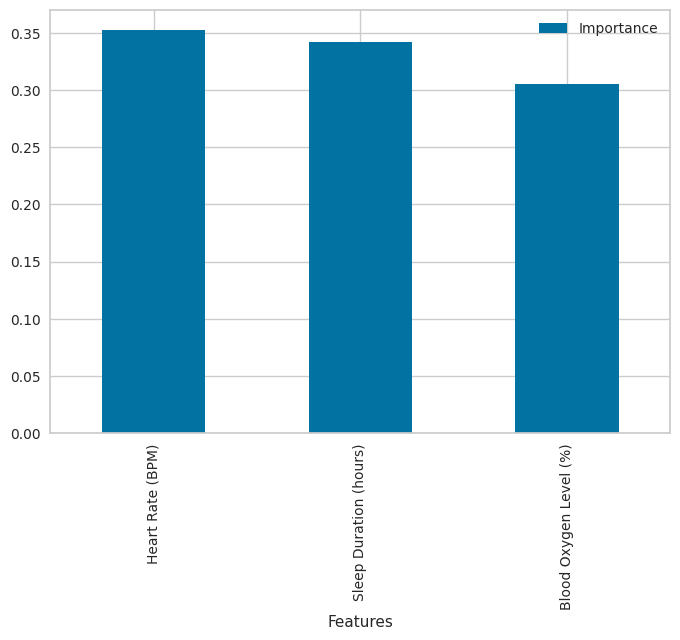

In [31]:

feature_importance_tree_based_models(model = pipeline2['model'],
                                     columns =  X_train2.columns[pipeline2['feature_selection'].get_support()]
                                     )

For Step Count, the best features in descending order : 
['Heart Rate (BPM)', 'Sleep Duration (hours)', 'Blood Oxygen Level (%)']

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
